# Calling NucDiff
#### DATE: 02-08-19
#### TASK: 
####       - Call NucDiff on reference file (H37rv) and query file (M. orygis or M. bovis)
####       - Return relevent information in a dataframe

In [87]:
import os, sys, io, random, subprocess
import string
import numpy as np
import pandas as pd
pd.set_option('display.width',150)
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

sys.path.append('/home/tortoise/pybioviz/')
from pybioviz import viewers, utils

import seaborn as sns

In [2]:
# Here, a set of features are defined.
# These features are what shall be extracted from inputted gff files, and are used as column headers in the dataframe
# Many titles will return as NaN however allows merging of different features, such as SNPs and Insertions
featurekeys = ['ID', 'Name', 'del_len', 'ins_len', 'query_bases', 'ref_bases', 'query_coord', 'start', 'end']
def features_to_dataframe(features, cds=False):
    """Get features from a biopython seq record object into a dataframe
    Args:
        features: bio seqfeatures
       returns: a dataframe with a row for each cds/entry.
      """
    
    #preprocess features
    allfeat = []
    for (item, f) in enumerate(features):
        x = f.__dict__
        q = f.qualifiers
        #print(q)
        x.update(q)
        d = {}
        d['start'] = f.location.start
        d['end'] = f.location.end
        #d['strand'] = f.location.strand
        for i in featurekeys:
            if i in x:
                if type(x[i]) is list:
                    d[i] = x[i][0]
                else:
                    d[i] = x[i]
        allfeat.append(d)

    df = pd.DataFrame(allfeat,columns=featurekeys)

    return df

In [15]:

# Here, the reference and query genomes are defined. Would be the command line arguments

# Reference:
mtb = 'ref_genomes/MTB_h37rv.fna'

# Query genomes:
mbovis = 'ref_genomes/mbovis.fna'
mafri = 'ref_genomes/mafricanum.fna'
mcan = 'ref_genomes/mcanettii.fna'
mcap = 'ref_genomes/mcap.fna'
mmic = 'ref_genomes/mmic.fna'
morygis = 'ref_genomes/morygis.fna'
mpin = 'ref_genomes/mpin.fna'

# Here, the genomes are added to a list for function parsing
# Would be automated using "for arg in sys.argv" loop
genome_list = [mbovis, mafri, mcan, mcap, mmic, morygis, mpin]

In [17]:
# Here the previous test NucDiff test folder is removed

remove_test = 'rm -r MTB_h37rv_mbovis'
code = os.system(remove_test)
print(code)

0


Here the NucDiff command is defined. Currently, it is hardcoded, but sys.argv arguments will be written in.


In [25]:
def run_nucdiff(ref, query_list):
    """Run nucdiff"""
    
    # This list will catch the output file names for easier parsing
    outputfolder_list = []
    
    # The list of genomes is iterated over
    for query in query_list:
    
        #The output folder name is defined from the query name
        outfolder = os.path.basename(ref).split('.')[0] + '_' +  os.path.basename(query).split('.')[0]
        
        # The folder name is appended to the list
        # We include '/results' as these are the main dub folder of interest
        outputfolder_list.append(outfolder + '/results')
        
        #The output prefix name is defined from the query name
        outprefix = os.path.basename(query).split('.')[0]

        # The command is defined using nucdiff and the reference genome of MTB, the query genome
        # The command also uses the defined output file name and prefix name
        nucDiffCmd = f'nucdiff {ref} {query} {outfolder} {outprefix}'

        # The command used is printed to screen...
        print (nucDiffCmd)

        # .. and called
        os.system(nucDiffCmd)
    
    # The folder names are returned
    return outputfolder_list

# The list is passed into the nucdiff calling function
# The list of names of the folders containing the results are captured
nucdiff_results = run_nucdiff(mtb, genome_list)

nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mbovis.fna MTB_h37rv_mbovis mbovis
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mafricanum.fna MTB_h37rv_mafricanum mafricanum
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mcanettii.fna MTB_h37rv_mcanettii mcanettii
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mcap.fna MTB_h37rv_mcap mcap
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mmic.fna MTB_h37rv_mmic mmic
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/morygis.fna MTB_h37rv_morygis morygis
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mpin.fna MTB_h37rv_mpin mpin
['MTB_h37rv_mbovis/results', 'MTB_h37rv_mafricanum/results', 'MTB_h37rv_mcanettii/results', 'MTB_h37rv_mcap/results', 'MTB_h37rv_mmic/results', 'MTB_h37rv_morygis/results', 'MTB_h37rv_mpin/results']


## find common differences morygis and mbovis vs mtb

In [21]:
# Here the features extracting function is defined
#featurekeys = ['ID', 'Name', 'del_len', 'ins_len', 'query_bases', 'ref_bases', 'query_coord', 'start', 'end']

def features_to_dataframe(features, cds=False):
    """Get features from a biopython seq record object into a dataframe
    Args:
        features: bio seqfeatures
       returns: a dataframe with a row for each cds/entry.
      """

    #preprocess features
    allfeat = []
    for (item, f) in enumerate(features):
        x = f.__dict__
        quals = f.qualifiers
        #print(q)
        x.update(quals)
        d = {}
        d['start'] = f.location.start
        d['end'] = f.location.end
        #d['strand'] = f.location.strand
     
        cols = list(quals.keys())+['start','end']
        for i in quals:
            if i in x:
                if type(x[i]) is list:
                    d[i] = x[i][0]
                else:
                    d[i] = x[i]
        allfeat.append(d)

    df = pd.DataFrame(allfeat,columns=cols)

    return df

In [102]:
#read in both gffs from nucdiff

# This extracts the snps from the snps.gff file and returns a dataframe
def get_nucdiff_snps(gff):
    feats = utils.gff_to_features(gff)
    df = features_to_dataframe(feats)
    results_df = df[df.Name=='substitution']
    return results_df

# This extracts the indels from the structs.gff file and returns a dataframe 
def get_nucdiff_indels(gff):
    feats = utils.gff_to_features(gff)
    df = features_to_dataframe(feats)
                                #results_df = df[(df.Name=='deletion') | (df.Name=='insertion')]
    # It was chosen to return all features, not just indels
    return df


In [68]:
df_list = []

# We iterate over the results file and extract features
for result_file in nucdiff_results:
    
    # We then iterate over each file in the results..
    for result in os.listdir(result_file):
        
        # .. and only parse the files of interest..
            """    if "ref_snps" in result:
            
            # .. and parse them through the SNPs retriever
            snps_df = get_nucdiff_snps(f'{result_file}/{result}')
            df_list.append(snps_df)
            print(f'{result_file}/{result}')
            
            print()   """
        # and same for indels
            if "ref_struct" in result:
            
                indels_df = get_nucdiff_indels(f'{result_file}/{result}')
                indels_df['Species'] = result.split('_')[0]
                df_list.append(indels_df)
                
            
indels = pd.concat(df_list)
#indels.groupby('start').agg({'Species':np.size})
indels[(indels.Name == 'deletion') | (indels.Name == 'insertion')][:10]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,ID,Name,Species,blk_query,blk_query_len,blk_ref,blk_ref_len,breakpoint_query,color,del_len,end,ins_len,query_coord,query_dir,query_sequence,ref_repeated_region,ref_repeated_region_1,ref_repeated_region_2,source,start
1,SV_2,insertion,mbovis,NaN,NaN,NaN,NaN,NaN,#EE0000,NaN,71586,NaN,71577-71611,1,Chromosome,NaN,NaN,NaN,NucDiff_v2.0,71585
3,SV_4,insertion,mbovis,NaN,NaN,NaN,NaN,NaN,#EE0000,NaN,150903,NaN,150915-151081,1,Chromosome,NaN,NaN,NaN,NucDiff_v2.0,150902
5,SV_6,deletion,mbovis,NaN,NaN,NaN,NaN,NaN,#0000EE,1902,266656,NaN,264979,1,Chromosome,NaN,NaN,NaN,NucDiff_v2.0,264754
6,SV_8,insertion,mbovis,NaN,NaN,NaN,NaN,NaN,#EE0000,NaN,334658,NaN,332983-333734,1,Chromosome,NaN,NaN,NaN,NucDiff_v2.0,334657
7,SV_7,deletion,mbovis,NaN,NaN,NaN,NaN,NaN,#0000EE,375,335033,NaN,332982,1,Chromosome,NaN,NaN,NaN,NucDiff_v2.0,334658
9,SV_11,insertion,mbovis,NaN,NaN,NaN,NaN,NaN,#EE0000,NaN,335602,NaN,336707-338924,1,Chromosome,NaN,NaN,NaN,NucDiff_v2.0,335601
12,SV_13,insertion,mbovis,NaN,NaN,NaN,NaN,NaN,#EE0000,NaN,362808,NaN,363811-363841,1,Chromosome,NaN,NaN,NaN,NucDiff_v2.0,362807
17,SV_18,insertion,mbovis,NaN,NaN,NaN,NaN,NaN,#EE0000,NaN,623297,NaN,624448-624514,1,Chromosome,NaN,NaN,NaN,NucDiff_v2.0,623296
19,SV_20,insertion,mbovis,NaN,NaN,NaN,NaN,NaN,#EE0000,NaN,742634,NaN,743871-744403,1,Chromosome,NaN,NaN,NaN,NucDiff_v2.0,742633
21,SV_22,deletion,mbovis,NaN,NaN,NaN,NaN,NaN,#0000EE,21,836893,NaN,838696,1,Chromosome,NaN,NaN,NaN,NucDiff_v2.0,836872


In [100]:
indels_only = indels[(indels.Name == 'deletion') | (indels.Name == 'insertion')]

start_table = pd.pivot_table(indels, index=['end'], columns=['Species'], aggfunc=np.sum, fill_value = 0)
start_table[start_table > 1] = 1
start_table = start_table[start_table.sum(1)>1]

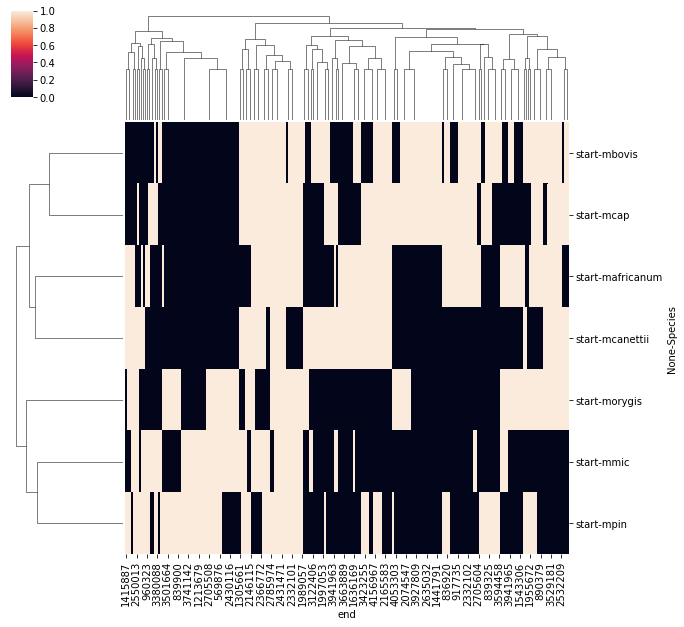

In [101]:
sns.clustermap(start_table.T)

In [ ]:
# This forms a combined snps and indels df for each strain            
mbovis_snpdels = pd.concat([mbovis_indels_df, mbovis_snps_df])
morygis_snpdels = pd.concat([morygis_indels_df, morygis_snps_df])

#common_differences = pd.merge(mbovis_snpdels, morygis_snpdels, on=['start', 'end'], how='inner')
#common_differences = common_differences.drop(columns=['ID_x', 'ID_y', 'query_coord_y', 'query_coord_x'])

common_indels = pd.merge(mbovis_indels_df, morygis_indels_df, on=['start', 'end'], how='inner').drop(columns=['ID_x',
                                                                    'ID_y', 'query_coord_y', 'query_coord_x', 'source_x', 'source_y', 
                                                                    'query_sequence_y', 'query_sequence_x', 
                                                                        'query_dir', 'color_y', 'color_x', 'Name_y'])
common_indels.rename(columns={'Name_x':'Name'}, inplace=True)
print(common_indels[15:25])
#merge them on start position

In [8]:
# Here the RD df is read in

def find_regions(data):
    """match regions of difference"""
    
    RD = pd.read_csv('RD.csv', comment='#')
    found=[]
    print (len(data))
    for i,r in data.iterrows():
        df = RD[((r.start>RD.Start) & (r.start<RD.Stop)) |
                  ((r.end>RD.Start) & (r.end<RD.Stop)) |
                  ((r.start<RD.Start) & (r.end>RD.Stop))]
        #df = RD[abs(RD.Start-r.start)<500]
        if len(df) > 0:
            #print (df)
            #print (r)
            df['indel_start'] = r.start
            df['indel_end'] = r.end
            df['name'] = r.Name
            df['del_len'] = r.end-r.start
            found.append(df)

    found = pd.concat(found)
    return found

mb = find_regions(mbovis_indels_df)
mo = find_regions(morygis_indels_df)
mbmo = find_regions(common_indels)

print (len(mb),len(mo))

189


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

314
66
32 31


In [9]:
set(mb.RD_name) & set(mo.RD_name)

{'RD10', 'RD11', 'RD14', 'RD182', 'RD207', 'RD5', 'RD7', 'RD8', 'RD9'}

In [10]:
mb.sort_values('del_len')

,RD_name,Start,Stop,Size,Rv,indel_start,indel_end,name,del_len
27,RD7,2207700,2220800,13100,Rv1964-Rv1977,2208004,2208005,relocation,1
32,RD12,3484809,3487711,2902,SseC-Rv3121,3487514,3487515,collapsed_repeat,1
8,RD207,3120521,3127920,7400,Rv2814c-2820c,3122405,3122406,tandem_duplication,1
29,RD9,2328974,2332879,3905,CobL-Rv2075,2332101,2332102,collapsed_repeat,1
27,RD7,2207700,2220800,13100,Rv1964-Rv1977,2220724,2220725,relocation,1
24,RD4,1695281,1708539,13258,Rv1505c-Rv1516c,1696015,1696016,relocation,1
28,RD8,4057733,4063249,5516,EphA-lpqG,4062733,4062734,collapsed_repeat,1
25,RD5,2625888,2635592,9704,Rv2346c-Rv2353c,2635030,2635032,collapsed_repeat,2
12,RD182,2545194,2551674,6481,Rv2270-2280,2551366,2551371,collapsed_repeat,5
33,RD13,1402778,1406084,3306,Rv1255c-Rv1257c,1405937,1405944,collapsed_repeat,7


In [11]:
#RD5:   NC_000962.3:2,625,888-2,635,592  Similar         (Not flagged as same)
#RD10:  NC_000962.3:264,067-267,764      Common
#RD9:   NC_000962.3:2,328,974-2,332,879  Common
#RD8    NC_000962.3:4,053,166-4,066,581  Common

In [12]:
mbmo

,RD_name,Start,Stop,Size,Rv,indel_start,indel_end,name,del_len
30,RD10,264067,267764,3697,Rv0221-Rv0223,264754,266656,deletion,1902
27,RD7,2207700,2220800,13100,Rv1964-Rv1977,2208004,2208005,relocation,1
27,RD7,2207700,2220800,13100,Rv1964-Rv1977,2220724,2220725,relocation,1
29,RD9,2328974,2332879,3905,CobL-Rv2075,2330073,2332101,deletion,2028
28,RD8,4057733,4063249,5516,EphA-lpqG,4056840,4062733,deletion,5893
